# An example of many-to-one (sequence classification)

Original experiment from [Hochreiter & Schmidhuber (1997)](www.bioinf.jku.at/publications/older/2604.pdf).

The goal is to classify sequences.
Elements and targets are represented locally (input vectors with only one non-zero bit).
The sequence starts with an `B`, ends with a `E` (the “trigger symbol”), and otherwise consists of randomly chosen symbols from the set `{a, b, c, d}` except for two elements at positions `t1` and `t2` that are either `X` or `Y`.
For the `DifficultyLevel.HARD` case, the sequence length is randomly chosen between `100` and `110`, `t1` is randomly chosen between `10` and `20`, and `t2` is randomly chosen between `50` and `60`.
There are `4` sequence classes `Q`, `R`, `S`, and `U`, which depend on the temporal order of `X` and `Y`.

The rules are:

```
X, X -> Q,
X, Y -> R,
Y, X -> S,
Y, Y -> U.
```

## 1. Dataset Exploration

In [1]:
from res.sequential_tasks import TemporalOrderExp6aSequence as QRSU

In [2]:
# Create a data generator
example_generator = QRSU.get_predefined_generator(
    difficulty_level=QRSU.DifficultyLevel.EASY,
    batch_size=32,
)

example_batch = example_generator[1]
print(f'The return type is a {type(example_batch)} with length {len(example_batch)}.')
print(f'The first item in the tuple is the batch of sequences with shape {example_batch[0].shape}.')
print(f'The first element in the batch of sequences is:\n {example_batch[0][0, :, :]}')
print(f'The second item in the tuple is the corresponding batch of class labels with shape {example_batch[1].shape}.')
print(f'The first element in the batch of class labels is:\n {example_batch[1][0, :]}')

The return type is a <class 'tuple'> with length 2.
The first item in the tuple is the batch of sequences with shape (32, 9, 8).
The first element in the batch of sequences is:
 [[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1]]
The second item in the tuple is the corresponding batch of class labels with shape (32, 4).
The first element in the batch of class labels is:
 [1. 0. 0. 0.]


In [3]:
# Decoding the first sequence
sequence_decoded = example_generator.decode_x(example_batch[0][0, :, :])
print(f'The sequence is: {sequence_decoded}')

# Decoding the class label of the first sequence
class_label_decoded = example_generator.decode_y(example_batch[1][0])
print(f'The class label is: {class_label_decoded}')

The sequence is: BbXcXcbE
The class label is: Q


## 2. Defining the Model

In [4]:
import torch
import torch.nn as nn

# Set the random seed for reproducible results
torch.manual_seed(1)

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        # This just calls the base class constructor
        super().__init__()
        # Neural network layers assigned as attributes of a Module subclass
        # have their parameters registered for training automatically.
        self.rnn = torch.nn.RNN(input_size, hidden_size, nonlinearity='relu', batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # The RNN also returns its hidden state but we don't use it.
        # While the RNN can also take a hidden state as input, the RNN
        # gets passed a hidden state initialized with zeros by default.
        h = self.rnn(x)[0]
        x = self.linear(h)
        return x

class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h = self.lstm(x)[0]
        x = self.linear(h)
        return x
    
    def get_states_across_time(self, x):
        h_c = None
        h_list, c_list = list(), list()
        with torch.no_grad():
            for t in range(x.size(1)):
                h_c = self.lstm(x[:, [t], :], h_c)[1]
                h_list.append(h_c[0])
                c_list.append(h_c[1])
            h = torch.cat(h_list)
            c = torch.cat(c_list)
        return h, c

## 3. Defining the Training Loop

In [5]:
def train(model, train_data_gen, criterion, optimizer, device):
    # Set the model to training mode. This will turn on layers that would
    # otherwise behave differently during evaluation, such as dropout.
    model.train()

    # Store the number of sequences that were classified correctly
    num_correct = 0

    # Iterate over every batch of sequences. Note that the length of a data generator
    # is defined as the number of batches required to produce a total of roughly 1000
    # sequences given a batch size.
    for batch_idx in range(len(train_data_gen)):

        # Request a batch of sequences and class labels, convert them into tensors
        # of the correct type, and then send them to the appropriate device.
        data, target = train_data_gen[batch_idx]
        data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

        # Perform the forward pass of the model
        output = model(data)  # Step ①

        # Pick only the output corresponding to last sequence element (input is pre padded)
        output = output[:, -1, :]

        # Compute the value of the loss for this batch. For loss functions like CrossEntropyLoss,
        # the second argument is actually expected to be a tensor of class indices rather than
        # one-hot encoded class labels. One approach is to take advantage of the one-hot encoding
        # of the target and call argmax along its second dimension to create a tensor of shape
        # (batch_size) containing the index of the class label that was hot for each sequence.
        target = target.argmax(dim=1)

        loss = criterion(output, target)  # Step ②

        # Clear the gradient buffers of the optimized parameters.
        # Otherwise, gradients from the previous batch would be accumulated.
        optimizer.zero_grad()  # Step ③

        loss.backward()  # Step ④

        optimizer.step()  # Step ⑤

        y_pred = output.argmax(dim=1)
        num_correct += (y_pred == target).sum().item()

    return num_correct, loss.item()

## 4. Defining the Testing Loop

In [6]:
def test(model, test_data_gen, criterion, device):
    # Set the model to evaluation mode. This will turn off layers that would
    # otherwise behave differently during training, such as dropout.
    model.eval()

    # Store the number of sequences that were classified correctly
    num_correct = 0

    # A context manager is used to disable gradient calculations during inference
    # to reduce memory usage, as we typically don't need the gradients at this point.
    with torch.no_grad():
        for batch_idx in range(len(test_data_gen)):
            data, target = test_data_gen[batch_idx]
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

            output = model(data)
            # Pick only the output corresponding to last sequence element (input is pre padded)
            output = output[:, -1, :]

            target = target.argmax(dim=1)
            loss = criterion(output, target)

            y_pred = output.argmax(dim=1)
            num_correct += (y_pred == target).sum().item()

    return num_correct, loss.item()

## 5. Putting it All Together

In [7]:
import matplotlib.pyplot as plt
from res.plot_lib import set_default, plot_state, print_colourbar

In [8]:
set_default()

In [9]:
def train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=True):
    # Automatically determine the device that PyTorch should use for computation
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # Move model to the device which will be used for train and test
    model.to(device)

    # Track the value of the loss function and model accuracy across epochs
    history_train = {'loss': [], 'acc': []}
    history_test = {'loss': [], 'acc': []}

    for epoch in range(max_epochs):
        # Run the training loop and calculate the accuracy.
        # Remember that the length of a data generator is the number of batches,
        # so we multiply it by the batch size to recover the total number of sequences.
        num_correct, loss = train(model, train_data_gen, criterion, optimizer, device)
        accuracy = float(num_correct) / (len(train_data_gen) * train_data_gen.batch_size) * 100
        history_train['loss'].append(loss)
        history_train['acc'].append(accuracy)

        # Do the same for the testing loop
        num_correct, loss = test(model, test_data_gen, criterion, device)
        accuracy = float(num_correct) / (len(test_data_gen) * test_data_gen.batch_size) * 100
        history_test['loss'].append(loss)
        history_test['acc'].append(accuracy)

        if verbose or epoch + 1 == max_epochs:
            print(f'[Epoch {epoch + 1}/{max_epochs}]'
                  f" loss: {history_train['loss'][-1]:.4f}, acc: {history_train['acc'][-1]:2.2f}%"
                  f" - test_loss: {history_test['loss'][-1]:.4f}, test_acc: {history_test['acc'][-1]:2.2f}%")

    # Generate diagnostic plots for the loss and accuracy
    fig, axes = plt.subplots(ncols=2, figsize=(9, 4.5))
    for ax, metric in zip(axes, ['loss', 'acc']):
        ax.plot(history_train[metric])
        ax.plot(history_test[metric])
        ax.set_xlabel('epoch', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.legend(['Train', 'Test'], loc='best')
    plt.show()

    return model

## 5. Simple RNN: 10 Epochs

[Epoch 1/10] loss: 1.4213, acc: 24.29% - test_loss: 1.3710, test_acc: 31.35%
[Epoch 2/10] loss: 1.3603, acc: 30.75% - test_loss: 1.3846, test_acc: 37.50%
[Epoch 3/10] loss: 1.3673, acc: 40.22% - test_loss: 1.3910, test_acc: 40.12%
[Epoch 4/10] loss: 1.3636, acc: 39.82% - test_loss: 1.3435, test_acc: 43.85%
[Epoch 5/10] loss: 1.2752, acc: 44.35% - test_loss: 1.3282, test_acc: 36.59%
[Epoch 6/10] loss: 1.2631, acc: 40.22% - test_loss: 1.2412, test_acc: 41.03%
[Epoch 7/10] loss: 1.2340, acc: 44.35% - test_loss: 1.2670, test_acc: 47.58%
[Epoch 8/10] loss: 1.1193, acc: 50.40% - test_loss: 1.2446, test_acc: 48.69%
[Epoch 9/10] loss: 1.2194, acc: 48.89% - test_loss: 1.1098, test_acc: 50.81%
[Epoch 10/10] loss: 1.0805, acc: 48.69% - test_loss: 1.0649, test_acc: 52.72%


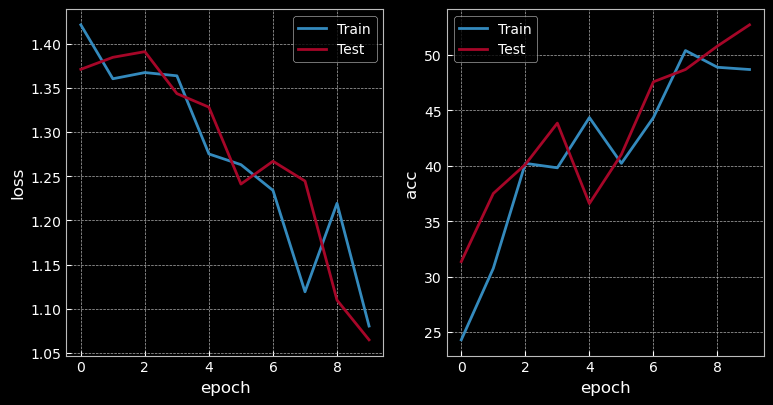

In [10]:
# Setup the training and test data generators
difficulty     = QRSU.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = SimpleRNN(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 10

# Train the model
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)

In [11]:
for parameter_group in list(model.parameters()):
    print(parameter_group.size())

torch.Size([4, 8])
torch.Size([4, 4])
torch.Size([4])
torch.Size([4])
torch.Size([4, 4])
torch.Size([4])


## 5. Simple LSTM: 10 Epochs

[Epoch 1/10] loss: 1.3307, acc: 32.66% - test_loss: 1.4515, test_acc: 29.03%
[Epoch 2/10] loss: 1.3932, acc: 28.02% - test_loss: 1.3997, test_acc: 26.01%
[Epoch 3/10] loss: 1.3456, acc: 37.40% - test_loss: 1.3411, test_acc: 50.71%
[Epoch 4/10] loss: 1.2591, acc: 49.19% - test_loss: 1.2757, test_acc: 53.93%
[Epoch 5/10] loss: 1.1803, acc: 48.89% - test_loss: 1.1728, test_acc: 50.50%
[Epoch 6/10] loss: 1.1296, acc: 58.77% - test_loss: 1.0896, test_acc: 71.98%
[Epoch 7/10] loss: 1.0777, acc: 77.72% - test_loss: 1.0764, test_acc: 80.14%
[Epoch 8/10] loss: 1.0456, acc: 82.56% - test_loss: 1.0916, test_acc: 95.06%
[Epoch 9/10] loss: 0.9874, acc: 96.27% - test_loss: 0.9321, test_acc: 99.40%
[Epoch 10/10] loss: 0.8819, acc: 97.98% - test_loss: 0.8538, test_acc: 99.90%


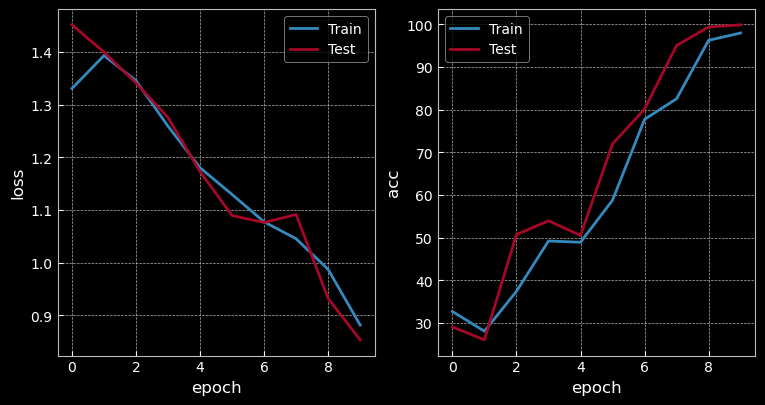

In [12]:
# Setup the training and test data generators
difficulty     = QRSU.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = SimpleLSTM(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 10

# Train the model
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)

In [13]:
for parameter_group in list(model.parameters()):
    print(parameter_group.size())

torch.Size([16, 8])
torch.Size([16, 4])
torch.Size([16])
torch.Size([16])
torch.Size([4, 4])
torch.Size([4])


## 6. RNN: Increasing Epoch to 100

[Epoch 100/100] loss: 0.0077, acc: 100.00% - test_loss: 0.0070, test_acc: 100.00%


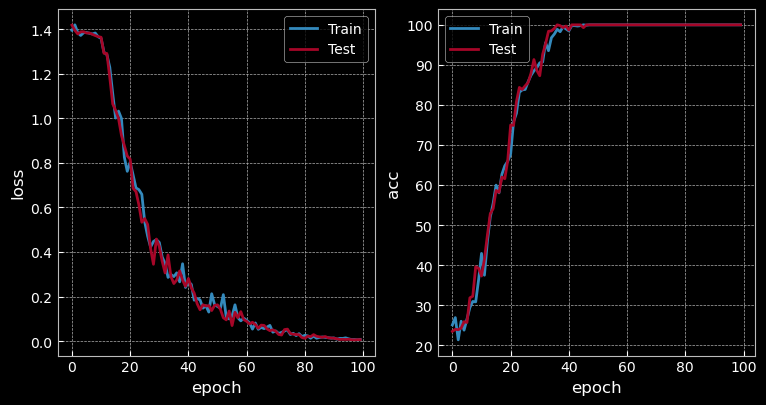

In [14]:
# Setup the training and test data generators
difficulty     = QRSU.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = SimpleRNN(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 100

# Train the model
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=False)

## LSTM: Increasing Epoch to 100

[Epoch 100/100] loss: 0.0017, acc: 100.00% - test_loss: 0.0017, test_acc: 100.00%


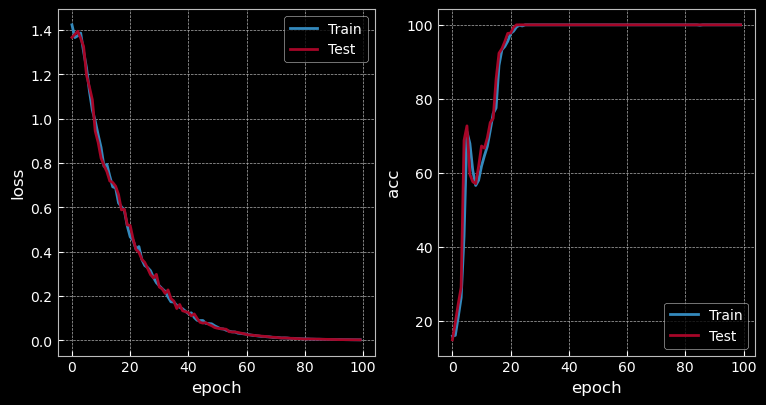

In [15]:
# Setup the training and test data generators
difficulty     = QRSU.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = SimpleLSTM(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 100

# Train the model
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=False)

## 7. Model Evaluation

In [16]:
import collections
import random

def evaluate_model(model, difficulty, seed=9001, verbose=False):
    # Define a dictionary that maps class indices to labels
    class_idx_to_label = {0: 'Q', 1: 'R', 2: 'S', 3: 'U'}

    # Create a new data generator
    data_generator = QRSU.get_predefined_generator(difficulty, seed=seed)

    # Track the number of times a class appears
    count_classes = collections.Counter()

    # Keep correctly classified and misclassified sequences, and their
    # true and predicted class labels, for diagnostic information.
    correct = []
    incorrect = []

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    model.eval()

    with torch.no_grad():
        for batch_idx in range(len(data_generator)):
            data, target = test_data_gen[batch_idx]
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

            data_decoded = data_generator.decode_x_batch(data.cpu().numpy())
            target_decoded = data_generator.decode_y_batch(target.cpu().numpy())

            output = model(data)
            output = output[:, -1, :]

            target = target.argmax(dim=1)
            y_pred = output.argmax(dim=1)
            y_pred_decoded = [class_idx_to_label[y.item()] for y in y_pred]

            count_classes.update(target_decoded)
            for i, (truth, prediction) in enumerate(zip(target_decoded, y_pred_decoded)):
                if truth == prediction:
                    correct.append((data_decoded[i], truth, prediction))
                else:
                    incorrect.append((data_decoded[i], truth, prediction))

    num_sequences = sum(count_classes.values())
    accuracy = float(len(correct)) / num_sequences * 100
    print(f'The accuracy of the model is measured to be {accuracy:.2f}%.\n')

    # Report the accuracy by class
    for label in sorted(count_classes):
        num_correct = sum(1 for _, truth, _ in correct if truth == label)
        print(f'{label}: {num_correct} / {count_classes[label]} correct')

    # Report some random sequences for examination
    print('\nHere are some example sequences:')
    for i in range(10):
        sequence, truth, prediction = correct[random.randrange(0, 10)]
        print(f'{sequence} -> {truth} was labelled {prediction}')

    # Report misclassified sequences for investigation
    if incorrect and verbose:
        print('\nThe following sequences were misclassified:')
        for sequence, truth, prediction in incorrect:
            print(f'{sequence} -> {truth} was labelled {prediction}')
    else:
        print('\nThere were no misclassified sequences.')

In [17]:
evaluate_model(model, difficulty)

The accuracy of the model is measured to be 100.00%.

Q: 258 / 258 correct
R: 249 / 249 correct
S: 232 / 232 correct
U: 253 / 253 correct

Here are some example sequences:
BcXbYdaE -> R was labelled R
BcYdYdaE -> U was labelled U
BcYdYdaE -> U was labelled U
BbXcXbcE -> Q was labelled Q
BcYdYdaE -> U was labelled U
BYdcaYbE -> U was labelled U
BbXaXdE -> Q was labelled Q
BbXcXbcE -> Q was labelled Q
BdYcbXE -> S was labelled S
BYbdYabE -> U was labelled U

There were no misclassified sequences.


## 8. Visualize LSTM
Setting difficulty to `MODERATE` and `hidden_size` to 12.

[Epoch 100/100] loss: 0.0147, acc: 85.79% - test_loss: 0.0210, test_acc: 100.00%


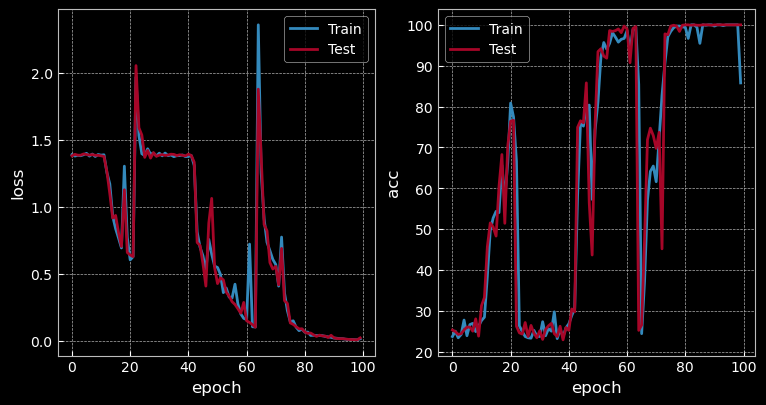

In [18]:
# For reproducibility
torch.manual_seed(1)

# Setup the training and test data generators
difficulty     = QRSU.DifficultyLevel.MODERATE
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 12
output_size = train_data_gen.n_classes
model       = SimpleLSTM(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 100

# Train the model
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=False)

In [19]:
# Get hidden (H) and cell (C) batch state given a batch input (X)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.eval()
with torch.no_grad():
    data = test_data_gen[0][0]
    X = torch.from_numpy(data).float().to(device)
    H_t, C_t = model.get_states_across_time(X)

In [20]:
print("Color range is as follows:")
print_colourbar()

Color range is as follows:


In [21]:
plot_state(X.cpu(), C_t, b=9, decoder=test_data_gen.decode_x)  # 3, 6, 9

In [22]:
plot_state(X.cpu(), H_t, b=9, decoder=test_data_gen.decode_x)